# Comment Vocabulary Analysis

## Load from CSV

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

projects = pd.read_csv('result/JavaProjectSample.csv')

# Drop data with < 100 of code, and no commits
projects = projects[projects['commits'] > 0]
projects = projects[projects['lines_of_code'] > 100]
projects = projects[projects['src_file_size'] > 0]

projects['comment_density'] = projects['lines_of_comments'] / projects['lines_of_code']
projects['comment_portion'] = projects['comment_size'] / projects['src_file_size']
projects['comments'] = projects['doc_comment'] + projects['impl_comment']
projects['comment_per_file'] = projects['comments'] / projects['src_files']
projects['doc_comment_per_file'] = projects['doc_comment'] / projects['src_files']
projects['impl_comment_per_file'] = projects['impl_comment'] / projects['src_files']
projects['popularity'] = [('High' if x >= 1000 else ('Mid' if x >= 100 else 'Low')) for x in projects['stars']]

sns.set(style='white')

projects.describe()

,size,stars,watchers,forks,commits,authors,lines_of_code,lines_of_comments,lines_blank,src_files,src_file_size,comment_size,doc_comment,impl_comment,comment_density,comment_portion,comments,comment_per_file,doc_comment_per_file,impl_comment_per_file
count,8.870000e+02,887.000000,887.000000,887.000000,887.000000,887.000000,8.870000e+02,8.870000e+02,8.870000e+02,887.000000,8.870000e+02,8.870000e+02,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000
mean,7.749039e+04,1598.199549,1598.199549,539.139797,5941.121759,133.555806,1.072550e+05,4.074207e+04,2.178048e+04,1028.649380,6.270337e+06,1.676637e+06,3993.346110,7607.099211,0.324380,0.215971,11600.445321,9.736894,3.109440,6.627454
std,1.791800e+05,4002.397714,4002.397714,1431.237803,21487.526445,242.002138,2.995368e+05,1.805191e+05,6.180781e+04,2735.188603,1.978542e+07,7.548992e+06,16497.319686,28258.012471,0.244137,0.118963,40944.658434,11.938294,3.334604,10.420271
min,4.620000e+02,0.000000,0.000000,0.000000,502.000000,1.000000,1.020000e+02,4.000000e+00,2.100000e+01,4.000000,2.807000e+03,1.710000e+02,0.000000,2.000000,0.000815,0.003124,7.000000,0.121951,0.000000,0.024643
25%,5.956000e+03,15.500000,15.500000,11.000000,920.000000,23.000000,1.178350e+04,2.589000e+03,2.501000e+03,141.500000,6.373885e+05,9.695050e+04,227.000000,485.000000,0.164705,0.129808,785.000000,3.998846,1.077835,2.517590
50%,2.072600e+04,304.000000,304.000000,111.000000,1945.000000,62.000000,2.948900e+04,8.057000e+03,6.314000e+03,354.000000,1.633251e+06,3.106990e+05,720.000000,1404.000000,0.280677,0.213309,2368.000000,6.738908,2.168142,4.326531
75%,6.833100e+04,1457.000000,1457.000000,455.000000,4741.000000,148.000000,8.319450e+04,2.630500e+04,1.686100e+04,886.500000,4.495258e+06,1.018200e+06,2388.500000,4587.500000,0.435671,0.289864,7319.500000,11.791077,4.033851,7.561177
max,2.389684e+06,48989.000000,48989.000000,19706.000000,550545.000000,3972.000000,5.015770e+06,4.358214e+06,1.089598e+06,52755.000000,3.526416e+08,1.823837e+08,351684.000000,509233.000000,3.156340,0.708274,651398.000000,227.800000,38.931818,222.718868


## Utilities

In [3]:
import json
import math
import numpy as np
import wordcloud
import matplotlib.pyplot as plt

def normalize(v):
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

def cos_similarity(u, v):
    return np.dot(u, v) / (math.sqrt(np.dot(u, u)) * math.sqrt(np.dot(v, v)))

def find_similar_projects(name, count):
    similarities = []
    for index, row in projects.iterrows():
        if row['name'] == name:
            continue
        similarities.append(
            (row['name'], cos_similarity(tfidf_vectors[name], tfidf_vectors[row['name']]))
        )
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[0:count]

def create_wordcloud(proj_name):
    with open('temp/comment_feature/{}.json'.format(proj_name), 'r') as f:
        comment_data = json.load(f)
    bag_of_words = [(word, stat) for word, stat in comment_data['bag_of_words'].items()]
    bag_of_words.sort(key=lambda x: x[1]['tfidf'], reverse=True)
    print(proj_name, [w[0] for w in bag_of_words[0:20]])
    freq_dict={}
    for word, stat in bag_of_words:
        freq_dict[word] = stat['tfidf']
    wc = wordcloud.WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(freq_dict)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Create TF-IDF Vectors

In [4]:
num_projects = len(projects['name'])
vocabs = set()
tfidf_vectors = {}
for index, row in projects.iterrows():
    with open('temp/comment_feature/{}.json'.format(row['name']), 'r') as f:
        comment_data = json.load(f)
    bag_of_words = comment_data['bag_of_words']
    for word in bag_of_words:
        vocabs.add(word)
vocabs = list(vocabs)
vocabs_index_dict = {}
for index, word in enumerate(vocabs):
    vocabs_index_dict[word] = index
for index, row in projects.iterrows():
    with open('temp/comment_feature/{}.json'.format(row['name']), 'r') as f:
        comment_data = json.load(f)
    bag_of_words = comment_data['bag_of_words']
    tfidf_vectors[row['name']] = np.zeros(len(vocabs))
    for word in bag_of_words:
        tfidf_vectors[row['name']][vocabs_index_dict[word]] = bag_of_words[word]['tfidf']
    tfidf_vectors[row['name']] = normalize(tfidf_vectors[row['name']])

## Several Intriguing Examples

[('sherxon_AlgoDS', 0.6609182223627394), ('mitcc_AlgoSolutions', 0.5582376737387955), ('shahajipatil22_New-Java', 0.5263985379227626)]
mission-peace_interview ['complexity', 'vertex', 'palindrome', 'tree', 'problem', 'node', 'graph', 'sum', 'subsequence', 'binary', 'preorder', 'edge', 'matrix', 'traversal', 'word', 'solution', 'coin', 'black', 'author', 'distance']


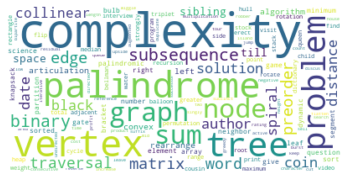

sherxon_AlgoDS ['complexity', 'vertex', 'solution', 'node', 'heap', 'solve', 'create', 'tree', 'element', 'graph', 'splay', 'pivot', 'weight', 'edge', 'word', 'palindrome', 'binary', 'iterative', 'disk', 'prime']


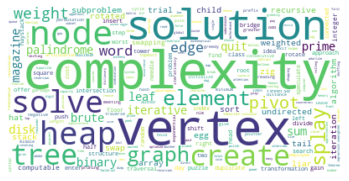

mitcc_AlgoSolutions ['node', 'tree', 'singly', 'challenge', 'binary', 'palindrome', 'integer', 'solution', 'sum', 'matrix', 'house', 'give', 'board', 'subsequence', 'example', 'coin', 'definition', 'number', 'complexity', 'sample']


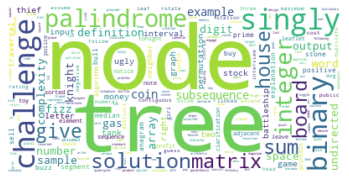

shahajipatil22_New-Java ['vertex', 'heap', 'matrix', 'edge', 'node', 'decimal', 'element', 'graph', 'distance', 'stack', 'cipher', 'algorithm', 'columnar', 'queue', 'rear', 'coin', 'print', 'binary', 'transposition', 'author']


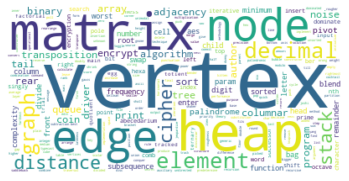

In [5]:
def visualize_similar_projects(proj_name, count):
    similar_projects = find_similar_projects(proj_name, count)
    print(similar_projects)
    create_wordcloud(proj_name)
    for p in similar_projects:
        create_wordcloud(p[0])
    
visualize_similar_projects('mission-peace_interview', 3)

[('BluSunrize_ImmersiveEngineering', 0.3100027214670724), ('McJtyMods_RFTools', 0.2899081497255275), ('BuildCraft_BuildCraft', 0.24558409125050157), ('Choonster-Minecraft-Mods_TestMod3', 0.21573261263129542), ('Thutmose_Pokecube', 0.19917258598287385)]
Electrical-Age_ElectricalAge ['electrical', 'turtle', 'energy', 'nominal', 'thermal', 'computer', 'peripheral', 'cable', 'tile', 'node', 'voltage', 'network', 'mount', 'entity', 'player', 'inventory', 'wireless', 'driver', 'packet', 'world']


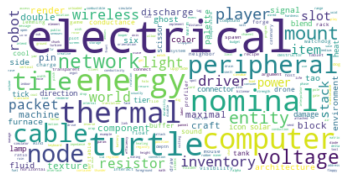

BluSunrize_ImmersiveEngineering ['tile', 'texture', 'face', 'revolver', 'entity', 'shader', 'energy', 'world', 'vertex', 'achievement', 'inventory', 'recipe', 'fluid', 'stack', 'slot', 'uncoloured', 'player', 'colour', 'immersive', 'drill']


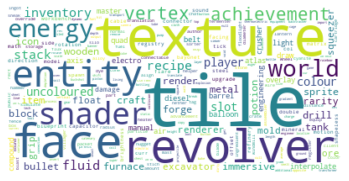

McJtyMods_RFTools ['achievement', 'energy', 'player', 'shield', 'inventory', 'dimension', 'screen', 'transmitter', 'elevator', 'wrench', 'entity', 'module', 'craft', 'tick', 'peripheral', 'computer', 'render', 'compound', 'tile', 'dial']


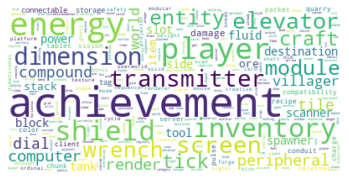

BuildCraft_BuildCraft ['fluid', 'pipe', 'recipe', 'tank', 'sprite', 'tile', 'texture', 'craft', 'inventory', 'render', 'colour', 'simplex', 'world', 'stack', 'item', 'player', 'block', 'face', 'gate', 'grad']


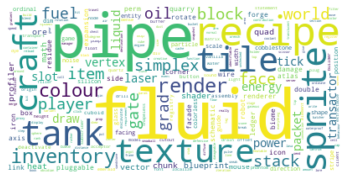

Choonster-Minecraft-Mods_TestMod3 ['player', 'pig', 'forum', 'fluid', 'inventory', 'spawner', 'loot', 'slab', 'potion', 'capability', 'energy', 'variant', 'entity', 'chunk', 'item', 'health', 'block', 'world', 'topic', 'chest']


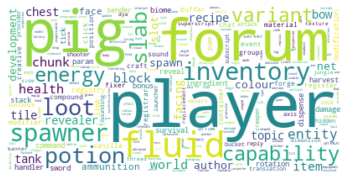

Thutmose_Pokecube ['mob', 'player', 'entity', 'trainer', 'attack', 'world', 'inventory', 'fertilizer', 'spawn', 'fruit', 'evolution', 'stack', 'biome', 'ranch', 'grindable', 'tick', 'egg', 'cable', 'packet', 'damage']


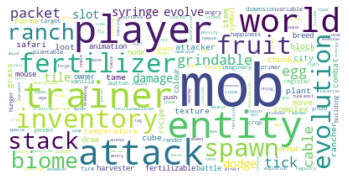

In [6]:
visualize_similar_projects('Electrical-Age_ElectricalAge', 5)

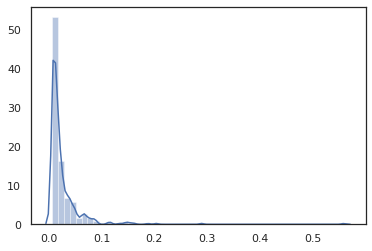

In [6]:
series = [x[1] for x in find_similar_projects('FranckRJ_RespawnIRC-Android', 500)]
sns.distplot(series)

## Perform LDA on Comment Vocabulary Data

In [7]:
from gensim.models import LdaModel
from gensim.models.tfidfmodel import TfidfModel
from gensim.corpora import Dictionary

corpus = []
comment_stopwords = [
    'author', 'return', 'param'
]

for index, row in projects.iterrows():
    text = []
    with open('temp/comment_feature/{}.json'.format(row['name']), 'r') as f:
        comment_data = json.load(f)
    bag_of_words = comment_data['bag_of_words']
    for word in bag_of_words:
        if word in comment_stopwords:
            continue
        text.extend([word] * bag_of_words[word]['count'])
    corpus.append(text)
    
dictionary = Dictionary(corpus)
bow = [dictionary.doc2bow(text) for text in corpus]
tfidf = TfidfModel(bow)
lda = LdaModel([tfidf[text] for text in bow], num_topics=10, id2word=dictionary)

lda.print_topics()

[(0,
  '0.001*"vertex" + 0.001*"node" + 0.001*"tree" + 0.001*"repository" + 0.001*"android" + 0.001*"player" + 0.001*"eclipse" + 0.001*"camera" + 0.001*"document" + 0.001*"tile"'),
 (1,
  '0.001*"android" + 0.001*"node" + 0.001*"activity" + 0.001*"link" + 0.001*"texture" + 0.001*"table" + 0.001*"view" + 0.001*"eclipse" + 0.001*"device" + 0.001*"hive"'),
 (2,
  '0.001*"node" + 0.001*"facet" + 0.001*"shard" + 0.001*"eclipse" + 0.001*"player" + 0.001*"flow" + 0.001*"spring" + 0.001*"link" + 0.001*"date" + 0.001*"entity"'),
 (3,
  '0.001*"song" + 0.001*"token" + 0.001*"android" + 0.001*"schema" + 0.001*"crossover" + 0.001*"link" + 0.001*"doc" + 0.001*"node" + 0.001*"intent" + 0.001*"transaction"'),
 (4,
  '0.001*"link" + 0.001*"session" + 0.001*"node" + 0.001*"doc" + 0.001*"response" + 0.001*"activity" + 0.001*"player" + 0.001*"android" + 0.001*"code" + 0.001*"attribute"'),
 (5,
  '0.001*"node" + 0.001*"entity" + 0.001*"document" + 0.001*"project" + 0.001*"repository" + 0.001*"image" + 0.0

## Clustering with DBSCAN

In [8]:
from sklearn.cluster import DBSCAN

proj2id = {}
vectors = []
for proj in tfidf_vectors:
    proj2id[proj] = len(vectors)
    vectors.append(tfidf_vectors[proj])
dist_matrix = np.zeros((len(vectors), len(vectors)))
for i in range(0, len(vectors)):
    for j in range(0, len(vectors)):
        dist_matrix[i][j] = 1 / (cos_similarity(vectors[i], vectors[j]) + 0.0001)
        
db = DBSCAN(eps=4, metric='precomputed').fit(dist_matrix)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 216


The result of DBSCAN indicates that, using the cosine similarity measure, the differences of comments in different projects are somewhat continuous (e.g. All projects form a dense cloud with no obvious clusters)